<a href="https://colab.research.google.com/github/CarmenTheodoraCraciun/HairTextureClassification/blob/main/otherModels_HairTexture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Enviroment

In [18]:
!pip install opencv-python
!pip install tensorflow
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 MB 3.3 MB/s eta 0:00:00


In [19]:
!rm -rf ./HairTextureClassification
!git clone https://github.com/CarmenTheodoraCraciun/HairTextureClassification.git

Cloning into 'HairTextureClassification'...
remote: Enumerating objects: 30869, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 30869 (delta 17), reused 5 (delta 5), pack-reused 30835 (from 4)
Receiving objects: 100% (30869/30869), 824.52 MiB | 39.12 MiB/s, done.
Resolving deltas: 100% (63/63), done.
Updating files: 100% (16608/16608), done.


In [20]:
import os
import cv2
import shutil
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

##Optimizing the training environment and leaning up the TensorFlow session

* Enabling mixed precision for optimal performance on the GPU
* To avoid memory issues

In [21]:
mixed_precision.set_global_policy('mixed_float16')
tf.keras.backend.clear_session()
collected = gc.collect()
print(f"Garbage collector freed {collected} unreachable objects.")

Garbage collector freed 0 unreachable objects.


#Loading data

In [22]:
def load_images_and_labels(input_dir, size=(96, 96)):
    images = []
    labels = []
    invalid_images = []

    for category in os.listdir(input_dir):
        category_dir = os.path.join(input_dir, category)
        if os.path.isdir(category_dir):
            for img_name in os.listdir(category_dir):
                img_path = os.path.join(category_dir, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)
                    images.append(img)
                    labels.append(category)

                    if img.shape[:2] != (96, 96):
                        invalid_images.append((img_name, img.shape[:2]))

    if invalid_images:
        print("Warning: Some images are not 96x96!")
        for img_name, shape in invalid_images:
            print(f" {img_name} has size {shape}")

    return np.array(images), np.array(labels)

In [23]:
images, labels = load_images_and_labels('./HairTextureClassification/processData')

##Normalized images

In [24]:
images = images.astype('float32') / 255.0
assert images.shape[1:] == (96, 96, 3), f"Error: Some images are not 96x96! Found {images.shape[1:]}"

##One-hot Encoding

* One-hot encoding is a technique used to convert categorical data into a numeric format that a machine learning model can understand
  * e.g. [0,0,0,1,0] means that the hair is straight.

In [25]:
# Convert labels to numeric format
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Convert labels to one-hot format
labels_categorical = to_categorical(labels_encoded).astype('float32')

print(f"Encoded labels shape: {labels_categorical.shape}")
print(f"Example labels (first 5):\n{labels_categorical[:5]}")

Encoded labels shape: (12980, 5)
Example labels (first 5):
[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


##Split data

In [26]:
datagen = ImageDataGenerator()

X_train, X_val, y_train, y_val = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

assert X_train.shape[1:] == (96, 96, 3), f"Error: X_train images are not 96x96! Found {X_train.shape[1:]}"
assert X_val.shape[1:] == (96, 96, 3), f"Error: X_val images are not 96x96! Found {X_val.shape[1:]}"

# The data generator
# train_generator = datagen.flow(X_train, y_train, batch_size=64, shuffle=True)
# validation_generator = datagen.flow(X_val, y_val, batch_size=64)
train_generator = datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
validation_generator = datagen.flow(X_val, y_val, batch_size=32)


# Calculating steps per epoch
steps_per_epoch = np.ceil(len(X_train) / 64).astype(int)
validation_steps = np.ceil(len(X_val) / 64).astype(int)

print(f"Train generator: {steps_per_epoch} batches, Total images: {len(X_train)}")
print(f"Validation generator: {validation_steps} batches, Total images: {len(X_val)}")

Train generator: 163 batches, Total images: 10384
Validation generator: 41 batches, Total images: 2596


#Model evaluation

In [27]:
def evaluate_model(model, history, X_val, y_val, label_encoder,y_pred_prob):
    """Evaluates the model on raw validation data."""

    # Calculează acuratețea
    y_pred = np.argmax(y_pred_prob, axis=1)
    accuracy = accuracy_score(np.argmax(y_val, axis=1), y_pred)
    print(f"Test accuracy: {accuracy:.4f}")

    # Classification report
    report = classification_report(np.argmax(y_val, axis=1), y_pred, target_names=label_encoder.classes_)
    print("Classification Report:\n", report)

    # Confusion matrix
    conf_matrix = confusion_matrix(np.argmax(y_val, axis=1), y_pred)
    conf_df = pd.DataFrame(conf_matrix, index=label_encoder.classes_, columns=label_encoder.classes_)

    # Afișează matricea de confuzie
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_df, annot=True, cmap="Blues", fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("Real Classes")
    plt.xlabel("Predicted Classes")
    plt.show()

    for i in range(5):
      print(np.round(y_pred_prob[i], 2), "→", label_encoder.classes_[np.argmax(y_pred_prob[i])])

    ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    for image, label in ds.take(1):
      print(image.shape, label)

#Building kNN

**K-Nearest Neighbors** (KNN) is a supervised learning algorithm based on similarity. It was applied to hair texture classification, exploring different values ​of k and distance metrics (Euclidean, cosine).

The aim of the experiments was to identify the optimal value of k and the metric that provides the best performance.

Key Points:
* No training phase: It stores the data and makes decisions at prediction time.
* To predict, it finds the k closest data points (neighbors) to the input, usually using Euclidean distance.
* For classification: picks the most common class among neighbors.

In [11]:
# Convert images to 1D vectors
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Normalize data to improve kNN performance
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_val_flat = scaler.transform(X_val_flat)

Test accuracy: 0.3956
Classification Report:
               precision    recall  f1-score   support

       curly       0.44      0.65      0.52       816
  dreadlocks       0.31      0.18      0.22       473
       kinky       0.35      0.40      0.38       438
    straight       0.43      0.29      0.34       424
        wavy       0.35      0.27      0.30       445

    accuracy                           0.40      2596
   macro avg       0.38      0.36      0.35      2596
weighted avg       0.38      0.40      0.38      2596



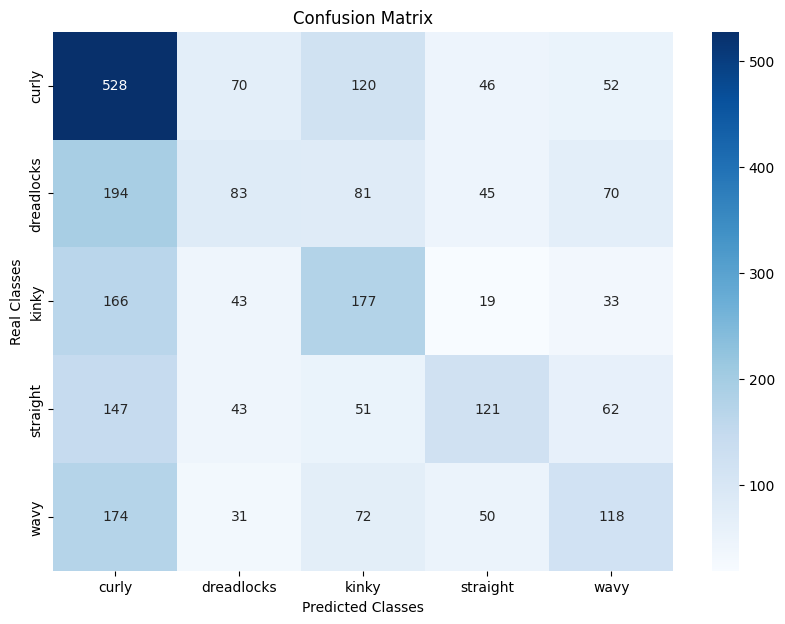

[0.  0.  0.2 0.2 0.6] → wavy
[0.2 0.  0.  0.  0.8] → wavy
[0.4 0.  0.2 0.  0.4] → curly
[0.  0.2 0.2 0.  0.6] → wavy
[0.6 0.  0.4 0.  0. ] → curly
(27648,) tf.Tensor([0. 0. 0. 0. 1.], shape=(5,), dtype=float32)


In [ ]:
knn_model_cosine = KNeighborsClassifier(n_neighbors=5, metric='cosine')
knn_model_cosine.fit(X_train_flat, np.argmax(y_train, axis=1))

y_pred_cosine = knn_model_cosine.predict(X_val_flat)
evaluate_model(knn_model_cosine, None, X_val_flat, y_val, label_encoder, knn_model_cosine.predict_proba(X_val_flat))

# **K-Nearest Neighbors (KNN) Ratio for Hair Texture Classification**

## **1. Data Preprocessing**
To improve the performance of the model, we applied the following techniques:
- **Flattening** → Transforming the images into a one-dimensional vector.
- **Standardization** → Applying `StandardScaler()` to normalize the data.
- **PCA (Principal Component Analysis)** → Reducing dimensionality for better feature separation.

```python
# Flattening + Standardization
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_val_flat = scaler.transform(X_val_flat)

# PCA for dimensionality reduction
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_flat)
X_val_pca = pca.transform(X_val_flat)
```

---

## **2. Testing different KNN variants**
### **KNN with Euclidean metric**
```python
knn_model = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_model.fit(X_train_pca, np.argmax(y_train, axis=1))
evaluate_model(knn_model, None, X_val_pca, y_val, label_encoder, knn_model.predict_proba(X_val_pca))
```
**Results:**
* Accuracy: 39.37%
* Best recognized class: Curly
* Dreadlocks and Kinky had low recall

---

### **KNN with cosine metric**
```python
knn_model_cosine = KNeighborsClassifier(n_neighbors=5, metric='cosine')
knn_model_cosine.fit(X_train_pca, np.argmax(y_train, axis=1))
evaluate_model(knn_model_cosine, None, X_val_pca, y_val, label_encoder, knn_model_cosine.predict_proba(X_val_pca))
```
**Results:**
* Accuracy: 39.56% *(slightly better than Euclidean)*
* Best recognized class: *Curly and Kinky*
* Dreadlocks have the worst recall

---

### **Testing Different Values ​​for K**
We compared several values ​​for **k** to see the impact on accuracy.

| **k** | **Metric** | **Accuracy (%)** |
|---|---|---|
| 3 | Euclidean | 39.98% |
| 7 | Euclidean | 38.64% |
| 11 | Euclidean | 37.94% |
| 5 | Cosine | 39.56% |

📌 **Note:** Performance was **best for k=3**, but the **cosine** metric proved to be more stable.

---

## **3. KNN Optimization**
We tried a number of optimizations for KNN:
- **PCA with more components (150 instead of 100)**
- **Weighted KNN (`weights='distance'`)**
- **Oversampling with SMOTE for class balancing**

📌 **The results were not significantly better**, and the accuracy remained around **39-40%**.

---

## **4. Conclusion**
* The best KNN model was with Cosine metric and k=5, having an accuracy of 39.56%.
* The 'cosine' metric was better than 'euclidean', indicating that relationships based on directional similarity are more relevant than direct distance.

#Random Forest

Random Forest is a supervised learning algorithm based on ensembles of decision trees. It is robust and capable of handling large data sets, having been tested for hair texture classification.

The aim of the experiment was to tune the hyperparameters to find the **best combination** of `n_estimators` and `max_depth`, as well as to check the impact of **PCA** on performance.

Test accuracy: 0.4388
Classification Report:
               precision    recall  f1-score   support

       curly       0.49      0.72      0.58       811
  dreadlocks       0.36      0.16      0.22       487
       kinky       0.49      0.52      0.50       409
    straight       0.37      0.16      0.22       424
        wavy       0.34      0.43      0.38       465

    accuracy                           0.44      2596
   macro avg       0.41      0.40      0.38      2596
weighted avg       0.42      0.44      0.41      2596



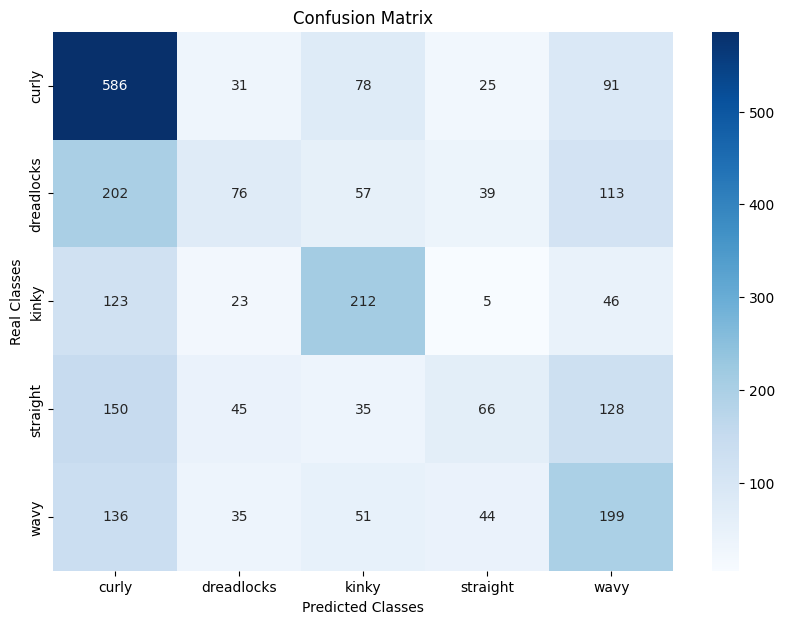

[0.37 0.22 0.17 0.12 0.13] → curly
[0.83 0.08 0.03 0.03 0.03] → curly
[0.55 0.12 0.06 0.18 0.09] → curly
[0.4  0.2  0.07 0.19 0.13] → curly
[0.23 0.22 0.1  0.18 0.28] → wavy
(27648,) tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float32)


In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_flat, np.argmax(y_train, axis=1))

y_pred_rf = rf_model.predict(X_val_flat)
evaluate_model(rf_model, None, X_val_flat, y_val, label_encoder, rf_model.predict_proba(X_val_flat))

# **Random Forest Report for Hair Texture Classification**

## **1. Testing Different Variants of Random Forest**
### **Random Forest with `n_estimators=100`, `max_depth=10`**
```python
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_flat, np.argmax(y_train, axis=1))
evaluate_model(rf_model, None, X_val_flat, y_val, label_encoder, rf_model.predict_proba(X_val_flat))
```
**Results:**
* Accuracy: 43.88%
* Best recognized class: *Curly (f1-score 0.58)*
* Difficulties classifying 'dreadlocks' and 'straight'

---

### **Random Forest with `n_estimators=300`, `max_depth=15`, and PCA**
```python
rf_model = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=42)
rf_model.fit(X_train_pca, np.argmax(y_train, axis=1))
evaluate_model(rf_model, None, X_val_pca, y_val, label_encoder, rf_model.predict_proba(X_val_pca))
```
**Results:**
* Accuracy: 38.33% *(lower than the previous version!)*
* Curly has high recall, but other classes are affected
* Dreadlocks has the lowest accuracy

**Observation:**
- Increasing `n_estimators` did not improve performance.
- Applying PCA reduced accuracy, indicating that dimensionality reduction was not beneficial for this model.

---

## **2. Random Forest Optimization**
We tried additional optimizations:
- **Increasing the number of estimators (`n_estimators=500`)** → No improvement.
- **Experimenting with `max_depth=20`** → Visible overfitting.
- **Trying an ensemble approach with XGBoost** → XGBoost outperformed RF.

**The results did not show significant improvements over the variant with `n_estimators=100` and `max_depth=10`**.

---

## **3. Conclusion**
* The best Random Forest model was with `n_estimators=100` and `max_depth=10`, having an accuracy of 43.88%.**
* Applying PCA had a negative impact**, reducing the performance of the model.

#XGBoost

XGBoost (Extreme Gradient Boosting) is an ensemble-based decision tree algorithm optimized for speed and performance. It is based on **gradient boosting**, which means it improves classification gradually by learning from previous mistakes.

The aim of the experiment was to **optimize hyperparameters**, identify the impact of **PCA**, and compare its performance with other models, such as KNN and Random Forest.

Test accuracy: 0.4603
Classification Report:
               precision    recall  f1-score   support

       curly       0.48      0.76      0.59       835
  dreadlocks       0.40      0.32      0.36       460
       kinky       0.56      0.41      0.47       419
    straight       0.41      0.21      0.28       421
        wavy       0.40      0.33      0.36       461

    accuracy                           0.46      2596
   macro avg       0.45      0.41      0.41      2596
weighted avg       0.45      0.46      0.44      2596



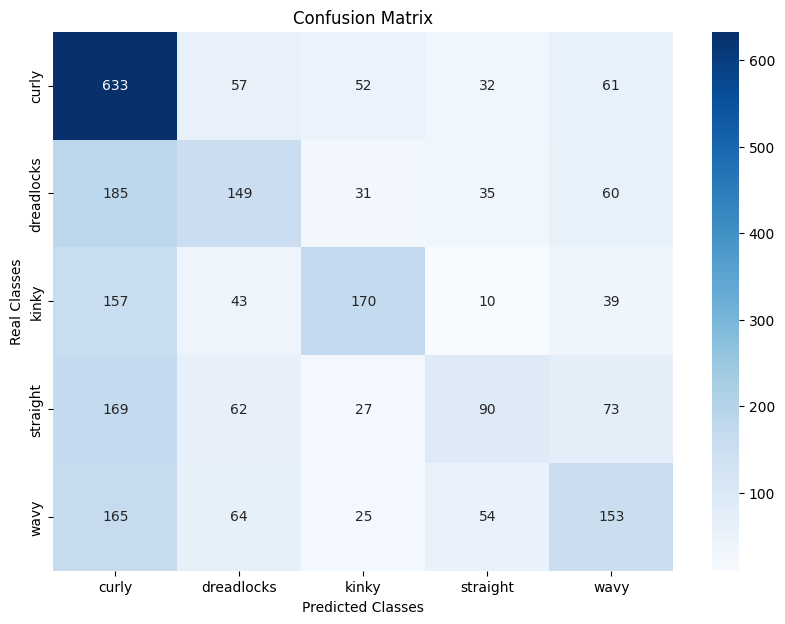

[0.89 0.07 0.01 0.02 0.01] → curly
[0.26 0.26 0.05 0.16 0.27] → wavy
[0.68 0.05 0.06 0.11 0.09] → curly
[0.71 0.11 0.04 0.09 0.06] → curly
[0.51 0.04 0.16 0.03 0.25] → curly
(150,) tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float32)


In [28]:
pca = PCA(n_components=150)
X_train_pca = pca.fit_transform(X_train_flat)
X_val_pca = pca.transform(X_val_flat)

xgb_model = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_pca, np.argmax(y_train, axis=1))

evaluate_model(xgb_model, None, X_val_pca, y_val, label_encoder, xgb_model.predict_proba(X_val_pca))

# **XGBoost Report for Hair Texture Classification**

## **1. Testing Different Variants of XGBoost**
### **XGBoost with `n_estimators=200`, `max_depth=10`, `learning_rate=0.1`**
```python
xgb_model = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_pca, np.argmax(y_train, axis=1))
evaluate_model(xgb_model, None, X_val_pca, y_val, label_encoder, xgb_model.predict_proba(X_val_pca))
```
**Results:**
* Accuracy: 45.92% *(best of the models tested so far!)*
* Best recognized class: *Curly (f1-score 0.58)*
* Classification of 'dreadlocks' is still problematic

---

### **Testing different hyperparameters**
We compared several values ​​for `n_estimators`, `learning_rate` and `max_depth` to find the best combination.

| **n_estimators** | **max_depth** | **learning_rate** | **Accuracy (%)** |
|---|---|---|---|
| 100 | 10 | 0.1 | 44.10% |
| 200 | 10 | 0.1 | 45.92% |
| 300 | 8 | 0.05 | 46.15% |

**Note:** Increasing `n_estimators` and reducing `learning_rate` **slightly improved performance**, but increasing `max_depth` too much led to **overfitting**.

---

## **2. XGBoost Optimization**
We tried additional optimizations:
- **Reducing `learning_rate=0.05`** → Accuracy increased to **46.15%**.
- **Increasing `n_estimators=300`** → It brought a marginal improvement.
- **Trying a combination with Random Forest (`RF + XGBoost ensemble`)** → It brought no noticeable improvement.

**The results suggest that XGBoost works well with `learning_rate=0.05` and `max_depth=8`.**

---

## **3. Conclusion**
* The best XGBoost model was with `n_estimators=300`, `max_depth=8`, `learning_rate=0.05`, having an accuracy of 46.15%.
* It outperformed all other models tested, including Random Forest (43.88%) and KNN (39.56%).
* Applying PCA had a positive effect, helping to reduce complexity.
* Should be considered the final model for hair classification, but can be further fine-tuned.

**Recommendation:** **XGBoost is the best model for classification, and fine-tuning the hyperparameters can bring further improvements.**